# Tarea 3

**Big data**

Profesor: Luis Alexander Calvo Valverde.

Instituto Tecnológico de Costa Rica,

Medio de entrega: TecDigital.

Grupo de trabajo:

    Manuel Calderón
    Ernesto Rivera


# Datos elegidos

## Variable de predicción

Si los ingresos exceden los $50K/año según los datos del censo

Link: https://www.kaggle.com/datasets/uciml/adult-census-income?resource=download


Los datos fueron extraídos de la base de datos de la oficina del Censo de 1994 por Ronny Kohavi y Barry Becker (Data Mining and Visualization, Silicon Graphics). Se extrajo un conjunto de registros razonablemente limpios usando las siguientes condiciones: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). La tarea de predicción es determinar si una persona gana más de $50,000 al año.


## Descripción de fnlwgt (peso final)

Los pesos en los archivos de la Encuesta de Población Actual (CPS) se controlan según estimaciones independientes de la población civil no institucional de los EE. UU.  Estos son preparados mensualmente por la División de Población en la Oficina del Censo. Se usan 3 conjuntos de controles. Estos son:

1. Una estimación de una sola celda de la población mayor de 16 años para cada estado.
1. Controles de origen hispano por edad y sexo.
1. Controles por raza, edad y sexo.

El término estimación se refiere a los totales de población derivados de CPS mediante la creación de "recuentos ponderados" de cualquier característica socioeconómica específica de la población. Las personas con características demográficas similares deberían tener pesos similares. Hay una advertencia importante para recordar acerca de esta declaración: dado que la muestra de CPS es en realidad una colección de 51 muestras estatales, cada una con su propia probabilidad de selección, la declaración solo se aplica dentro del estado.

In [1]:
import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)
from pyspark.sql.functions import when, col, concat
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array
import seaborn as sns
import matplotlib.pyplot as plt


## Para cargar los datos en diferentes sistemas operativos

Comente o descomente las siguientes líneas dependiendo en cuál sistema operativo tiene docker corriendo.

In [2]:
# mac o windows
database_url = "jdbc:postgresql://host.docker.internal:5433/postgres"

# linux
database_url = "jdbc:postgresql://172.17.0.1:5433/postgres"

____

# Lectura y limpieza

____

In [3]:
spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

adult_df = spark \
    .read \
    .format("csv") \
    .option("path", "adult.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("age", IntegerType()),
                StructField("workclass", StringType()),
                StructField("fnlwgt", IntegerType()),
                StructField("education", StringType()),
                StructField("education.num", IntegerType()),
                StructField("marital.status", StringType()),
                StructField("occupation", StringType()),
                StructField("relationship", StringType()),
                StructField("race", StringType()),
                StructField("sex", StringType()),
                StructField("capital.gain", IntegerType()),
                StructField("capital.loss", IntegerType()),
                StructField("hours.per.week", IntegerType()),
                StructField("native.country", StringType()),
                StructField("income", StringType())])) \
    .load()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/06 03:40:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
adult_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education.num: integer (nullable = true)
 |-- marital.status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital.gain: integer (nullable = true)
 |-- capital.loss: integer (nullable = true)
 |-- hours.per.week: integer (nullable = true)
 |-- native.country: string (nullable = true)
 |-- income: string (nullable = true)



In [5]:
adult_df.show(5)

+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|education.num|marital.status|       occupation| relationship| race|   sex|capital.gain|capital.loss|hours.per.week|native.country|income|
+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 90|        ?| 77053|     HS-grad|            9|       Widowed|                ?|Not-in-family|White|Female|           0|        4356|            40| United-States| <=50K|
| 82|  Private|132870|     HS-grad|            9|       Widowed|  Exec-managerial|Not-in-family|White|Female|           0|        4356|            18| United-States| <=50K|
| 66|        ?|186061|Some-college|           10|       Widowed|                ?|    Unmarried|Black|Female|           0|        4356|

In [6]:
adult_df.summary().show()

+-------+------------------+-----------+------------------+------------+-----------------+--------------+----------------+------------+------------------+------+------------------+-----------------+------------------+--------------+------+
|summary|               age|  workclass|            fnlwgt|   education|    education.num|marital.status|      occupation|relationship|              race|   sex|      capital.gain|     capital.loss|    hours.per.week|native.country|income|
+-------+------------------+-----------+------------------+------------+-----------------+--------------+----------------+------------+------------------+------+------------------+-----------------+------------------+--------------+------+
|  count|             32561|      32561|             32561|       32561|            32561|         32561|           32561|       32561|             32561| 32561|             32561|            32561|             32561|         32561| 32561|
|   mean| 38.58164675532078|       null|

In [7]:
# posibles valores para la columna 'income'

adult_df.select('income').distinct().collect()

[Row(income='<=50K'), Row(income='>50K')]

In [8]:
# se transforma la columna income a boolean,
# y se quitan los puntos '.' de los nombres de las columnas para evitar errores

adult_df = adult_df.withColumn("income_target", when(col("income") == ">50K", 1).otherwise(0)) \
    .withColumnRenamed("education.num", "education_num") \
    .withColumnRenamed("marital.status", "marital_status") \
    .withColumnRenamed("capital.gain", "capital_gain") \
    .withColumnRenamed("capital.loss", "capital_loss") \
    .withColumnRenamed("hours.per.week", "hours_week") \
    .withColumnRenamed("native.country", "native_country")
adult_df.printSchema()
adult_df.show(8)

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- income_target: integer (nullable = false)

+---+---------+------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+----------+--------------+------+-------------+
|age|workclass|fnlwgt|   education|education_num|marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hour

In [9]:
# Información descriptiva del dataframe

adult_df.describe(["workclass","marital_status","occupation",
                "relationship","race","sex","native_country"]).show()

adult_df.describe(["age","fnlwgt","education_num","capital_gain","capital_loss","hours_week"]).show()

adult_df.describe(["income_target"]).show()

+-------+-----------+--------------+----------------+------------+------------------+------+--------------+
|summary|  workclass|marital_status|      occupation|relationship|              race|   sex|native_country|
+-------+-----------+--------------+----------------+------------+------------------+------+--------------+
|  count|      32561|         32561|           32561|       32561|             32561| 32561|         32561|
|   mean|       null|          null|            null|        null|              null|  null|          null|
| stddev|       null|          null|            null|        null|              null|  null|          null|
|    min|          ?|      Divorced|               ?|     Husband|Amer-Indian-Eskimo|Female|             ?|
|    max|Without-pay|       Widowed|Transport-moving|        Wife|             White|  Male|    Yugoslavia|
+-------+-----------+--------------+----------------+------------+------------------+------+--------------+

+-------+------------------

In [10]:
# convertir de categorías textuales a numéricas

label_stringIdx = StringIndexer(inputCols = ["workclass","marital_status","occupation",
                "relationship","native_country"], 
                                outputCols = ["workclass_2", "marital_status_2","occupation_2",
                "relationship_2","native_country_2"])
model = label_stringIdx.fit(adult_df)
indexadas = model.transform(adult_df)
indexadas.show(5)

+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+----------+--------------+------+-------------+-----------+----------------+------------+--------------+----------------+
|age|workclass|fnlwgt|   education|education_num|marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_week|native_country|income|income_target|workclass_2|marital_status_2|occupation_2|relationship_2|native_country_2|
+---+---------+------+------------+-------------+--------------+-----------------+-------------+-----+------+------------+------------+----------+--------------+------+-------------+-----------+----------------+------------+--------------+----------------+
| 90|        ?| 77053|     HS-grad|            9|       Widowed|                ?|Not-in-family|White|Female|           0|        4356|        40| United-States| <=50K|            0|        3.0|             4.0|         7.0|     

In [11]:
# El objetivo que es el "income" - ahora "target"
# Se quitan: "age", "sex", "race", por estar incluídos en el cálculo de "fnlwgt", según descripción del dataset.

columns_kept = ["workclass_2","fnlwgt","education_num","marital_status_2","occupation_2",
                "relationship_2","capital_gain","capital_loss","hours_week",
                "native_country_2","income_target" ]
selected_columns_df = indexadas.select(columns_kept) \
    .withColumnRenamed("workclass_2", "workclass") \
    .withColumnRenamed("education_num", "education") \
    .withColumnRenamed("marital_status_2", "marital") \
    .withColumnRenamed("occupation_2", "occupation") \
    .withColumnRenamed("relationship_2", "relationship") \
    .withColumnRenamed("capital_gain", "gain") \
    .withColumnRenamed("capital_loss", "loss") \
    .withColumnRenamed("native_country_2", "country") \
    .withColumnRenamed("income_target", "target")

selected_columns_df.show(5)

+---------+------+---------+-------+----------+------------+----+----+----------+-------+------+
|workclass|fnlwgt|education|marital|occupation|relationship|gain|loss|hours_week|country|target|
+---------+------+---------+-------+----------+------------+----+----+----------+-------+------+
|      3.0| 77053|        9|    4.0|       7.0|         1.0|   0|4356|        40|    0.0|     0|
|      0.0|132870|        9|    4.0|       2.0|         1.0|   0|4356|        18|    0.0|     0|
|      3.0|186061|       10|    4.0|       7.0|         3.0|   0|4356|        40|    0.0|     0|
|      0.0|140359|        4|    2.0|       6.0|         3.0|   0|3900|        40|    0.0|     0|
|      0.0|264663|       10|    3.0|       0.0|         2.0|   0|3900|        40|    0.0|     0|
+---------+------+---------+-------+----------+------------+----+----+----------+-------+------+
only showing top 5 rows



In [12]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores

assembler = VectorAssembler(
    inputCols=["workclass","fnlwgt","education","marital","occupation",
                "relationship","gain","loss","hours_week",
                "country"],
    outputCol="features")

vector_df = assembler.transform(selected_columns_df)
vector_df.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[3.0,77053.0,9.0,...|
|[0.0,132870.0,9.0...|
|[3.0,186061.0,10....|
|[0.0,140359.0,4.0...|
|[0.0,264663.0,10....|
+--------------------+
only showing top 5 rows



22/05/06 03:40:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/06 03:40:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


<AxesSubplot:>

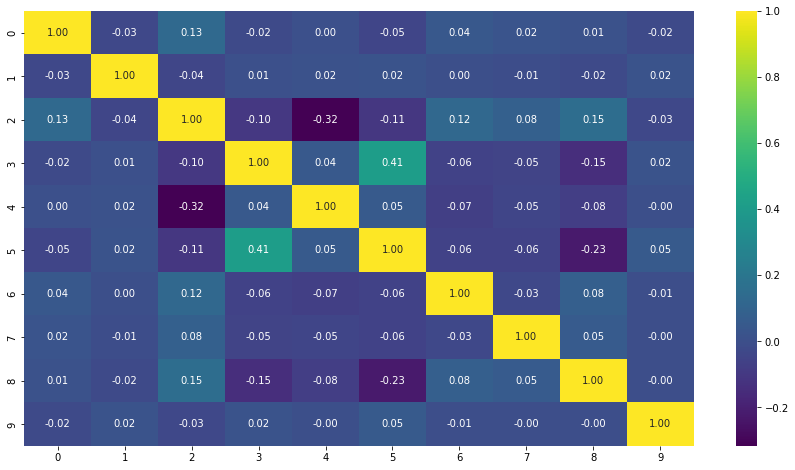

In [13]:
# Con la representación de vectores podemos calcular correlaciones

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

# pinta el heatmap grandote
plt.figure(figsize = (15,8))
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

# Estandarización
Como recordamos de los módulos anteriores es deseable que los datos se encuentren estandarizados o normalizados, para evitar que la magnitud de ciertos atributos dominen el proceso de entrenamiento. El módulo `pyspark.ml.feature` tiene varias alternativas. A continuación se presenta una.

In [14]:
standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(vector_df)
scaled_df = scale_model.transform(vector_df)
scaled_df.show(10)


+---------+------+---------+-------+----------+------------+----+----+----------+-------+------+--------------------+--------------------+
|workclass|fnlwgt|education|marital|occupation|relationship|gain|loss|hours_week|country|target|            features|              scaled|
+---------+------+---------+-------+----------+------------+----+----+----------+-------+------+--------------------+--------------------+
|      3.0| 77053|        9|    4.0|       7.0|         1.0|   0|4356|        40|    0.0|     0|[3.0,77053.0,9.0,...|[1.84473473501235...|
|      0.0|132870|        9|    4.0|       2.0|         1.0|   0|4356|        18|    0.0|     0|[0.0,132870.0,9.0...|[0.0,1.2588349415...|
|      3.0|186061|       10|    4.0|       7.0|         3.0|   0|4356|        40|    0.0|     0|[3.0,186061.0,10....|[1.84473473501235...|
|      0.0|140359|        4|    2.0|       6.0|         3.0|   0|3900|        40|    0.0|     0|[0.0,140359.0,4.0...|[0.0,1.3297871118...|
|      0.0|264663|       10

____

# Escritura de la tabla

____

In [15]:
expanded_df = scaled_df.withColumn("vec", vector_to_array("scaled", "float32")) \
    .select(["vec", "target"])

columnas_expanded = ["workclass", "fnlwgt", "education", "marital", "occupation", "relationship",
            "gain", "loss", "hours_week", "country"]
columnas_to_select = [col("vec")[i].alias(columnas_expanded[i]) for i in range(10)]
columnas_to_select.append(col("target"))

depurados_df = expanded_df.select(columnas_to_select)
depurados_df.show(5)

+---------+---------+---------+---------+----------+------------+----+--------+----------+-------+------+
|workclass|   fnlwgt|education|  marital|occupation|relationship|gain|    loss|hours_week|country|target|
+---------+---------+---------+---------+----------+------------+----+--------+----------+-------+------+
|1.8447348|0.7300144|3.4982426|3.6411223| 2.1472657|   0.7355963| 0.0|   10.81| 3.2395408|    0.0|     0|
|      0.0| 1.258835|3.4982426|3.6411223|0.61350447|   0.7355963| 0.0|   10.81| 1.4577934|    0.0|     0|
|1.8447348|1.7627763|3.8869362|3.6411223| 2.1472657|    2.206789| 0.0|   10.81| 3.2395408|    0.0|     0|
|      0.0|1.3297871|1.5547745|1.8205612| 1.8405135|    2.206789| 0.0|9.678374| 3.2395408|    0.0|     0|
|      0.0| 2.507466|3.8869362|2.7308419|       0.0|   1.4711926| 0.0|9.678374| 3.2395408|    0.0|     0|
+---------+---------+---------+---------+----------+------------+----+--------+----------+-------+------+
only showing top 5 rows



In [16]:
# Almacenar el conjunto de datos limpio en la base de datos

depurados_df \
    .write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", database_url) \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()


# Inspección de datos
Previo a entrenar el modelo es común que se realice algún tipo de descripción de los datos, para tener una idea del tipo de problema con el que nos enfrentamos. A continuación, algunas operacions útiles que podemos usar.


In [17]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

def leerDeTabla(nombreTabla): 
    df = spark \
        .read \
        .format("jdbc") \
        .option("url", database_url) \
        .option("user", "postgres") \
        .option("password", "testPassword") \
        .option("dbtable", nombreTabla) \
        .load()
    print("Lectura de tabla:", nombreTabla)
    df.show(5)
    return df

df = leerDeTabla("tarea3")

Lectura de tabla: tarea3
+---------+---------+---------+---------+----------+------------+----+--------+----------+-------+------+
|workclass|   fnlwgt|education|  marital|occupation|relationship|gain|    loss|hours_week|country|target|
+---------+---------+---------+---------+----------+------------+----+--------+----------+-------+------+
|1.8447348|0.7300144|3.4982426|3.6411223| 2.1472657|   0.7355963| 0.0|   10.81| 3.2395408|    0.0|     0|
|      0.0| 1.258835|3.4982426|3.6411223|0.61350447|   0.7355963| 0.0|   10.81| 1.4577934|    0.0|     0|
|1.8447348|1.7627763|3.8869362|3.6411223| 2.1472657|    2.206789| 0.0|   10.81| 3.2395408|    0.0|     0|
|      0.0|1.3297871|1.5547745|1.8205612| 1.8405135|    2.206789| 0.0|9.678374| 3.2395408|    0.0|     0|
|      0.0| 2.507466|3.8869362|2.7308419|       0.0|   1.4711926| 0.0|9.678374| 3.2395408|    0.0|     0|
+---------+---------+---------+---------+----------+------------+----+--------+----------+-------+------+
only showing top 5 ro

In [18]:
assembler = VectorAssembler(
    inputCols=["workclass","fnlwgt","education","marital","occupation",
                "relationship","gain","loss","hours_week","country"],
    outputCol="features")

vector_df = assembler.transform(df)

____

## Modelos de entrenamiento usando Cross-validator y evaluación
____

### Pasos previos

In [19]:
# importar bibliotecas
from pyspark.ml.classification import (LogisticRegression, MultilayerPerceptronClassifier,
                                    RandomForestClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# preparando dataset para el entrenamiento
df2 = assembler.transform(df).withColumnRenamed("target", "label")

# divide la data en entrenamiento y pruebas
(trainingData, testData) = df2.randomSplit([0.6, 0.4], 1234)

# objeto evaluador
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")


def guardarModelo(df, nombreTabla):
    df.select(["workclass", "fnlwgt", "education", "marital", "occupation", "relationship",
            "gain", "loss", "hours_week", "country", "prediction"]) \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", database_url) \
        .option("user", "postgres") \
        .option("password", "testPassword") \
        .option("dbtable", nombreTabla) \
        .save()
    print("Tabla guardada", nombreTabla)

In [20]:
testData.show(5)

+---------+----------+---------+---------+----------+------------+---------+----+----------+-------+-----+--------------------+
|workclass|    fnlwgt|education|  marital|occupation|relationship|     gain|loss|hours_week|country|label|            features|
+---------+----------+---------+---------+----------+------------+---------+----+----------+-------+-----+--------------------+
|      0.0|0.13045006|3.8869362|      0.0| 1.8405135|         0.0|      0.0| 0.0| 2.4296556|    0.0|    0|(10,[1,2,4,8],[0....|
|      0.0|0.17837048|3.8869362|0.9102806| 2.4540179|   0.7355963|      0.0| 0.0| 3.2395408|    0.0|    0|[0.0,0.1783704757...|
|      0.0|0.18287072|3.8869362|0.9102806|0.92025673|   0.7355963|      0.0| 0.0|  3.887449|    0.0|    0|[0.0,0.1828707158...|
|      0.0|0.18466134|3.8869362|0.9102806|0.30675223|   0.7355963|      0.0| 0.0| 3.2395408|    0.0|    0|[0.0,0.1846613436...|
|      0.0|0.18852681|3.4982426|      0.0|0.30675223|         0.0|2.0343137| 0.0| 3.6444836|    0.0|    

____

## 1. Multilayer Perceptron Classifier
____

In [21]:
# capas de la red neuronal:
# 10 (features), dos capas intermedias
# salida de dos clases
layers = [10, 5, 4, 2]

ml_trainer = MultilayerPerceptronClassifier()

grid = ParamGridBuilder() \
    .addGrid(ml_trainer.maxIter,[100]) \
    .addGrid(ml_trainer.layers, [layers]) \
    .addGrid(ml_trainer.blockSize,[128]) \
    .addGrid(ml_trainer.seed, [1234]) \
    .build()
evaluator = MulticlassClassificationEvaluator()
crossval = CrossValidator(estimator=ml_trainer, 
                          estimatorParamMaps=grid, 
                          evaluator=evaluator, 
                          parallelism=2,
                          numFolds=4)


ml_model = crossval.fit(trainingData)
ml_predictions = ml_model.transform(testData)

# evalúa, guarda y vuelve a leer
evaluacionModelo1 = evaluator.evaluate(ml_predictions)
guardarModelo(ml_predictions, "modelo1")
leerDeTabla("modelo1")
print("Precisión = %g" % (evaluacionModelo1))



Tabla guardada modelo1
Lectura de tabla: modelo1
+---------+----------+---------+---------+----------+------------+---------+----+----------+-------+----------+
|workclass|    fnlwgt|education|  marital|occupation|relationship|     gain|loss|hours_week|country|prediction|
+---------+----------+---------+---------+----------+------------+---------+----+----------+-------+----------+
|      0.0|0.13045006|3.8869362|      0.0| 1.8405135|         0.0|      0.0| 0.0| 2.4296556|    0.0|       0.0|
|      0.0|0.17837048|3.8869362|0.9102806| 2.4540179|   0.7355963|      0.0| 0.0| 3.2395408|    0.0|       0.0|
|      0.0|0.18287072|3.8869362|0.9102806|0.92025673|   0.7355963|      0.0| 0.0|  3.887449|    0.0|       0.0|
|      0.0|0.18466134|3.8869362|0.9102806|0.30675223|   0.7355963|      0.0| 0.0| 3.2395408|    0.0|       0.0|
|      0.0|0.18852681|3.4982426|      0.0|0.30675223|         0.0|2.0343137| 0.0| 3.6444836|    0.0|       1.0|
+---------+----------+---------+---------+----------+--

____

## 2. Random Forest Classifier
____

In [22]:
# Creación, Entrenamiento y Predicción del modelo

rf_trainer = RandomForestClassifier(labelCol="label",
                                    featuresCol="features", numTrees=10, maxBins = 42)

grid = ParamGridBuilder().build()
crossval = CrossValidator(estimator=rf_trainer,
                          estimatorParamMaps=grid,
                          evaluator=evaluator,
                          parallelism=2,
                          numFolds=4)

rf_model = crossval.fit(trainingData)
rf_predictions = rf_model.transform(testData)

# evalúa, guarda y vuelve a leer
evaluacionModelo2 = evaluator.evaluate(rf_predictions)
guardarModelo(rf_predictions, "modelo2")
leerDeTabla("modelo2")
print("Precisión = %g" % (evaluacionModelo2))


Tabla guardada modelo2
Lectura de tabla: modelo2
+---------+----------+---------+---------+----------+------------+---------+----+----------+-------+----------+
|workclass|    fnlwgt|education|  marital|occupation|relationship|     gain|loss|hours_week|country|prediction|
+---------+----------+---------+---------+----------+------------+---------+----+----------+-------+----------+
|      0.0|0.13045006|3.8869362|      0.0| 1.8405135|         0.0|      0.0| 0.0| 2.4296556|    0.0|       0.0|
|      0.0|0.17837048|3.8869362|0.9102806| 2.4540179|   0.7355963|      0.0| 0.0| 3.2395408|    0.0|       0.0|
|      0.0|0.18287072|3.8869362|0.9102806|0.92025673|   0.7355963|      0.0| 0.0|  3.887449|    0.0|       0.0|
|      0.0|0.18466134|3.8869362|0.9102806|0.30675223|   0.7355963|      0.0| 0.0| 3.2395408|    0.0|       0.0|
|      0.0|0.18852681|3.4982426|      0.0|0.30675223|         0.0|2.0343137| 0.0| 3.6444836|    0.0|       1.0|
+---------+----------+---------+---------+----------+--

## Análisis de resultados

**Resultado de Modelo 1 (Multilayer Perceptron Classifier)**

Usando Multilayer Perceptron, se obtienen buenos resultados con una precisión del 83% aproximadamente. Para este caso, solo se tuvo que aplicar las capas bien (inical con cantidad de features de entrada, salida con cantidad de clases del clasificador) y buscar una combinación que dé buenos resultados.


**Resultado de Modelo 2 (RandomForestClassifier)**

Usando Random Forest, se logran buenos resultados con una precisión del 83% aproximadamente, queda como aprendizaje que al principio se tuvieron problemas con los datos, dado que por defecto solo acepta un máximo de Bins de 32, pero en nuestro caso teníamos unos datos categóricos de 42 registros, por lo que para corregirlo se podía extender los bins o eliminar el campo, por lo que se decidió aumentar los BINS, que tuvo como resultado un aumento de la precisión.

**Comparación entre modelos**

Aplicando una comparación de los resultados las diferencias son mínimas donde ambas pruebas aplicaron un 83% aproximadamente.

Una diferencia a notar entre usar un evaluador normal y un evaluador utilizando el k-fold es que usando el segundo se obtuvo un resultado más preciso.